dead time effect = 0.9611151870873074


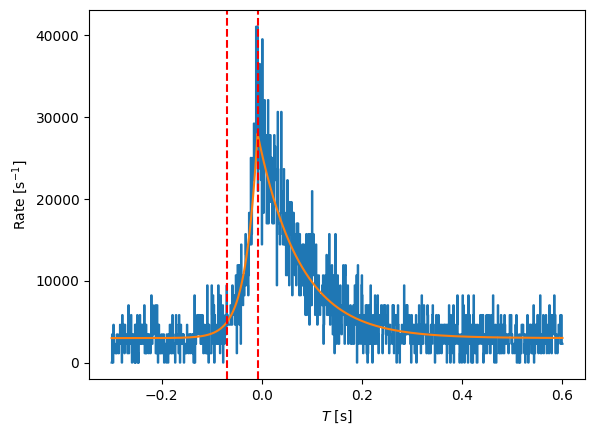

In [1]:
import matplotlib.pyplot as plt
import numba as nb
import numpy as np
from pycwt import fft, fft_kwargs


@nb.njit('float64[:](float64[::1], float64)')
def apply_non_extending_dead_time(t, dt):
    evts = np.empty_like(t)
    n = 0
    alive_time = t[0]
    for i in range(t.size):
        if t[i] >= alive_time:
            evts[n] = t[i]
            alive_time = t[i] + dt
            n += 1
    return evts[:n]


@nb.njit(nb.float64[:](nb.float64[:], nb.float64[:]))
def fred_vec(t, args):
    A, t_max, sigma_r, sigma_d, v, b = args
    sigma = np.where(t <= t_max, sigma_r, sigma_d)
    signal = A * np.exp(-(((np.abs(t - t_max)) / sigma) ** v)) + b
    return signal


@nb.njit(nb.float64(nb.float64, nb.float64[:]))
def fred(t, args):
    A, t_max, sigma_r, sigma_d, v, b = args
    sigma = sigma_r if t <= t_max else sigma_d
    signal = A * np.exp(-(((np.abs(t - t_max)) / sigma) ** v)) + b
    return signal


@nb.njit(
    nb.float64[:](
        nb.types.FunctionType(nb.float64(nb.float64, nb.float64[:])),
        nb.float64[:],
        nb.float64,
        nb.float64,
        nb.float64,
        nb.int64,
    )
)
def simulate_events(ft, args, ftmax, t0, t1, seed):
    """Algorithm 6"""
    np.random.seed(seed)
    t = t0
    events = []
    # i = 0
    while t <= t1:
        t = t - np.log(np.random.rand()) / ftmax
        if np.random.rand() <= ft(t, args) / ftmax:
            events.append(t)
    #    i += 1
    # events.append(i)
    return np.array(events)


t = np.arange(-0.3, 0.6, 0.00001)
pars = np.array([25000, -8.7e-3, 24.0e-3, 84.0e-3, 1.0, 3000])
# plt.plot(t, fred_vec(t, pars))
# plt.xlabel('$T$ [s]')
# plt.ylabel('Rate [s$^{-1}$]')
evts0 = simulate_events(fred, pars, 1000000.0, -0.3, 0.6, seed=42)

deadtime = 4e-6
evts = apply_non_extending_dead_time(evts0, deadtime)
print('dead time effect =', len(evts) / len(evts0))
bins = np.linspace(-0.3, 0.6, 2**10 + 1)
lc = np.histogram(evts, bins)[0]
expo = (
    np.diff(bins)
    - np.histogram(evts, bins, weights=np.ones_like(evts) * deadtime)[0]
)
rate = lc / expo
plt.figure()
plt.step(bins, np.append(rate, rate[-1]), where='post')
plt.plot(t, fred_vec(t, pars))
plt.xlabel('$T$ [s]')
plt.ylabel('Rate [s$^{-1}$]')
plt.axvline(-8.7 / 1000, color='r', ls='--')
plt.axvline(-8.7 / 1000 - 60 / 1000, color='r', ls='--')

In [2]:
def cwt(signal, variance, psi_ft_bar, fft_kwargs):
    data = signal  # (signal - signal.mean()) / np.sqrt(sigma2)
    data_ft = fft.fft(data, **fft_kwargs)
    ws = fft.ifft(data_ft * psi_ft_bar, **fft_kwargs, overwrite_x=True)
    mod = np.abs(ws)
    power = (mod * mod).sum(axis=-1)
    return power / variance

In [3]:
import pycwt

mother = pycwt.MexicanHat()
ls = ['-', '--', '-.', ':']
N = len(rate)
dt = bins[1] - bins[0]
dj = 1 / 24
s0 = 2 * dt / mother.flambda()
J = round((np.log2(N) - 1) / dj)

sj = s0 * 2 ** (np.arange(0, J + 1) * dj)
freqs = 1 / (mother.flambda() * sj)
sj_col = sj[:, None]
ftfreqs = 2 * np.pi * np.fft.fftfreq(N, dt)
psi_ft_bar = (sj_col * ftfreqs[1] * N) ** 0.5 * np.conjugate(
    mother.psi_ft(sj_col * ftfreqs)
)
# plt.scatter(1/freqs, cwt(rate, psi_ft_bar, fft_kwargs(rate))/sj, s=1)
# plt.loglog()
# plt.xlabel(r'$\delta t$ [s]')

In [4]:
import tqdm

nsim = 5000
bkg_simu = np.random.default_rng(42).poisson(dt * 3000, (nsim, N)) / dt
power_sim = np.empty((nsim, J + 1))

for i in tqdm.trange(nsim):
    power_sim[i] = cwt(
        bkg_simu[i],
        (bkg_simu[i] / dt).sum(),
        psi_ft_bar,
        fft_kwargs(bkg_simu[i]),
    )

100%|██████████| 5000/5000 [00:20<00:00, 249.67it/s]


In [5]:
from scipy.stats import chi2

dofmin = mother.dofmin
gamma = mother.gamma
period = 1 / freqs
coi = N / 2 - np.abs(np.arange(0, N) - (N - 1) / 2)
coi = mother.flambda() * mother.coi() * dt * coi
na = N - np.sum(period[:, None] >= coi, axis=1) / 2
edof = dofmin * np.sqrt(1 + (na * dt / (gamma * sj)) ** 2)
edof[edof < dofmin] = dofmin
upper1, median1, lower1 = (
    chi2.ppf(np.array([0.99, 0.5, 0.01])[:, None], edof) / edof
)

In [6]:
from scipy.stats import norm

sigma = 1
cl = 1 - 2 * norm.sf(sigma)
power = cwt(rate, sum(rate / expo), psi_ft_bar, fft_kwargs(rate)) / sj
power_err = power * (
    edof / (np.array([chi2.ppf(1 - cl * 0.5, edof), chi2.ppf(cl * 0.5, edof)]))
    - 1
)
power_err1 = np.abs(power_err)
power_err2 = np.sqrt(2 * edof) / edof * power

[]

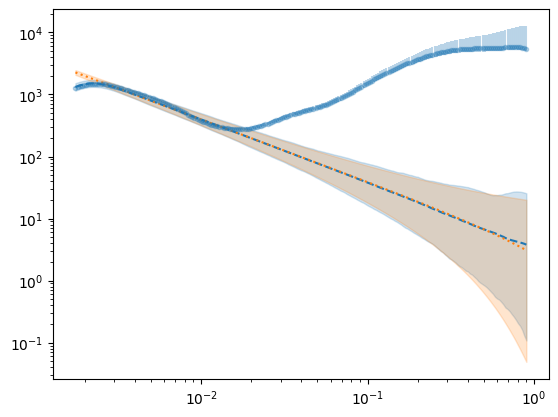

In [7]:
lower, median, upper = np.quantile(power_sim, q=[0.01, 0.5, 0.99], axis=0)
ci = chi2.ppf(np.array([0.99, 0.5, 0.01])[:, None], edof) / edof
plt.errorbar(1 / freqs, power, yerr=power_err1, fmt='. ', alpha=0.3)
# plt.errorbar(1/freqs, power, yerr=power_err2, fmt='. ', alpha=0.3)
plt.plot(1 / freqs, median / sj, '--', c='C0')
plt.plot(1 / freqs, median1 / sj, ':', c='C1')
plt.fill_between(1 / freqs, lower / sj, upper / sj, alpha=0.2, color='C0')
plt.fill_between(1 / freqs, lower1 / sj, upper1 / sj, alpha=0.2, color='C1')
plt.loglog()

In [8]:
# from scipy.stats import gamma
#
#
# def cdf(S, I, dof):
#     half_dof = 0.5 * dof
#     return gamma.cdf(I, a=half_dof, scale=S / half_dof)
#
#
# def sf(S, I, dof):
#     half_dof = 0.5 * dof
#     return gamma.sf(I, a=half_dof, scale=S / half_dof)
#
#
# def upper_fn(S, I, dof, cl):
#     return cdf(S, I, dof) - cl
#
#
# def lower_fn(S, I, dof, cl):
#     return sf(S, I, dof) - cl
#
#
# from scipy.optimize import root_scalar
#
# flag = np.zeros((J + 1, 2), dtype=bool)
# lower_err = np.empty_like(power)
# upper_err = np.empty_like(power)
# for i in range(J + 1):
#     p = power[i]
#     dof = edof[i]
#     res1 = root_scalar(
#         lower_fn, args=(p, dof, cl * 0.5), bracket=[0.1 * p, p]
#     )
#     if res1.converged:
#         lower_err[i] = res1.root
#         flag[i][0] = True
#     else:
#         lower_err[i] = -np.sqrt(2 * dof) / dof * p
#         flag[i][0] = False
#
#     res2 = root_scalar(
#         upper_fn, args=(p, dof, cl * 0.5), bracket=[p, p * 10]
#     )
#     if res2.converged:
#         upper_err[i] = res2.root
#         flag[i][1] = True
#     else:
#         upper_err[i] = -np.sqrt(2 * dof) / dof * p
#         flag[i][1] = False
#
# print('All converged:', np.all(flag))

All converged: True


[]

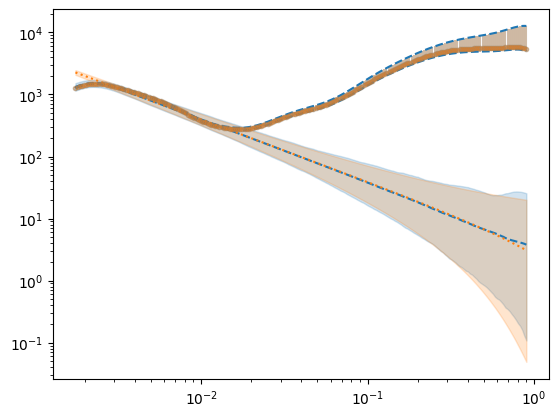

In [9]:
# power_err = power * (
#     edof / (
#         np.array([chi2.ppf(1 - cl * 0.5, edof), chi2.ppf(cl * 0.5, edof)])
#     ) - 1
# )
# plt.errorbar(1 / freqs, power, yerr=np.abs(power_err), fmt='. ', alpha=0.3)
# plt.errorbar(
#     1 / freqs,
#     power,
#     yerr=np.abs(np.array([lower_err, upper_err]) - power),
#     fmt='. ',
#     alpha=0.3,
# )
# plt.plot(1 / freqs, lower_err, '--', c='C0')
# plt.plot(1 / freqs, upper_err, '--', c='C0')
# plt.plot(1 / freqs, median / sj, '--', c='C0')
# plt.plot(1 / freqs, median1 / sj, ':', c='C1')
# plt.fill_between(1 / freqs, lower / sj, upper / sj, alpha=0.2, color='C0')
# plt.fill_between(1 / freqs, lower1 / sj, upper1 / sj, alpha=0.2, color='C1')
# plt.loglog()

(0.003, 0.6)

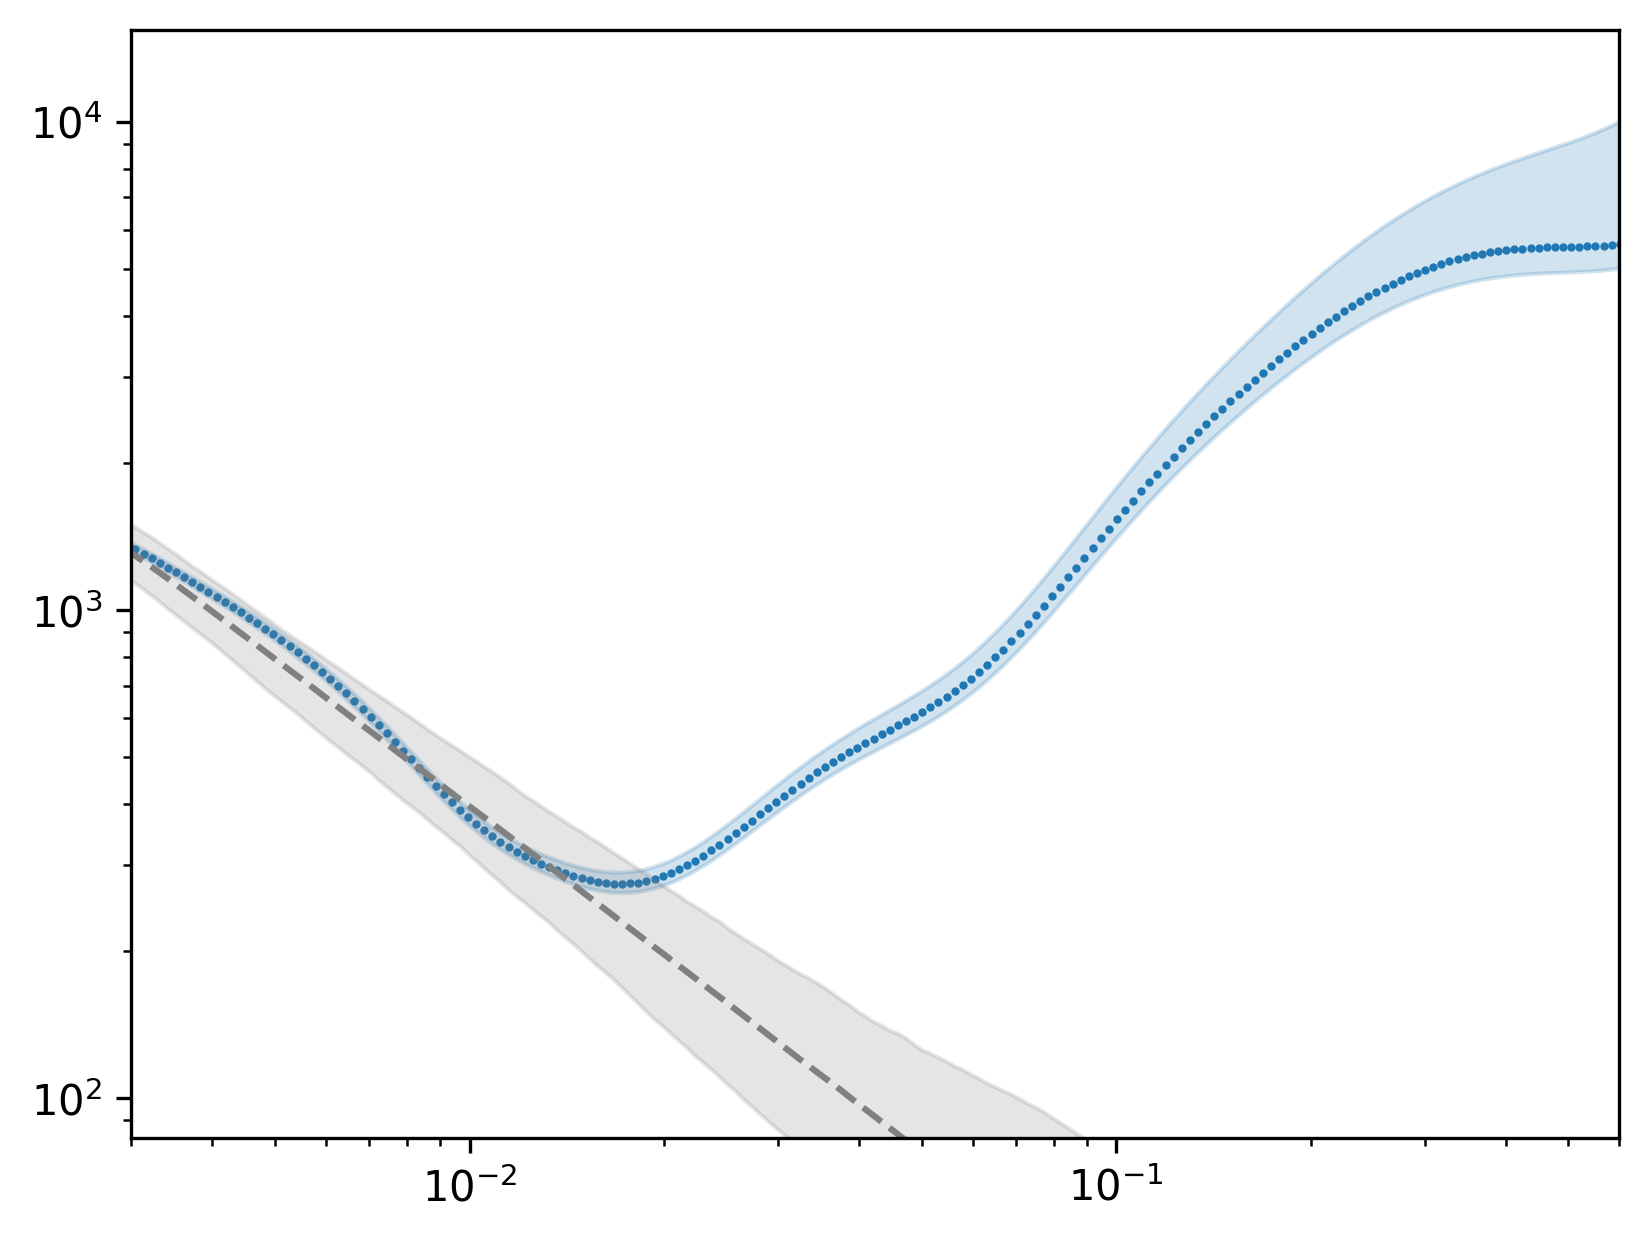

In [10]:
power_lower, power_upper = (
    power
    * edof
    / (np.array([chi2.ppf(1 - cl * 0.5, edof), chi2.ppf(cl * 0.5, edof)]))
)
plt.figure(dpi=300)
plt.scatter(period, power, s=1)
plt.fill_between(
    period, power_lower, power_upper, ls='-', color='C0', alpha=0.2
)
plt.loglog()
ymin, ymax = plt.gca().get_ylim()
plt.ylim(np.exp(np.log(ymin) - np.log(ymax - ymin) / 10), ymax)
plt.plot(1 / freqs, median / sj, '--', c='gray')
plt.fill_between(1 / freqs, lower / sj, upper / sj, alpha=0.2, color='gray')
plt.xlim(3e-3, 0.6)

In [11]:
import numpy as np


def get_mvt(period, power, back_power):
    i = np.flatnonzero(power < back_power)[-1]
    x1, x2 = period[i - 1], period[i]
    y1_1, y1_2 = power[i - 1], power[i]
    y2_1, y2_2 = back_power[i - 1], back_power[i]
    # linear interpolation
    return x1 + (0 - (y1_1 - y2_1)) * (x2 - x1) / (
        (y1_2 - y2_2) - (y1_1 - y2_1)
    )


print(get_mvt(period, power, upper / sj))
print(get_mvt(period, power_upper, upper / sj))
print(get_mvt(period, power_lower, upper / sj))

0.019357160085427604
0.01836780160616128
0.01992329579565597
